<a href="https://colab.research.google.com/github/RosarioH10062002/connectivity-biomarkers-pd-depression/blob/main/ISP_Process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LIBRARIES**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
import math
from collections import Counter
from scipy.io import loadmat
try:
    import nilearn
    from nilearn import image as nimg
    from nilearn import plotting
    from nilearn.connectome import ConnectivityMeasure

except ImportError:
    !pip install nilearn
    import nilearn
    from nilearn import image as nimg
    from nilearn import plotting as nplot
    from nilearn.connectome import ConnectivityMeasure



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**UPLOAD DATA**

In [ ]:

root_path_pd = Path("/content/drive/MyDrive/M2/Impact Scholar Programme/Preprocessed_data/CONN_PREPROCESS_PD")
root_path_pd_dep = Path("/content/drive/MyDrive/M2/Impact Scholar Programme/Preprocessed_data/CONN_PREPROCESS_PD_DEP")
root_path_ctrl = Path("/content/drive/MyDrive/M2/Impact Scholar Programme/Preprocessed_data/CONN_PREPROCESS_CTRL")

#pd_subjects = [100005,100006,100007,100018,100268,101018,101146]#,101174,101476,101479,101735,101742,101751,101841,102012,102053,102078,102305,102321,102420]
#ctrl_subjects = [108909,113043,113050,113369,115698,116230,116231]#,128335,130028,138022,142086,149120,149716,156484,160890,161329,165043,167746,178413,101195,102447,103161,103183,103467,103542] #103542
#pd_subjects_dep =  [100267,100842,101050,102978,174141,182427,184432]
pd_subjects = [100005, 100006, 100007, 100018, 100268]
ctrl_subjects = [101195, 102447, 103161, 103183, 103467]
pd_subjects_dep = [101050, 102978, 174141, 182427, 184432]


#report
print(f'control subjects: {len(ctrl_subjects)} \n parkinson subjects (no depressed): {len(pd_subjects)} \n parkinson subjects (depressed): {len(pd_subjects_dep)}')


control subjects: 5 
 parkinson subjects (no depressed): 5 
 parkinson subjects (depressed): 5


In [146]:
path_list = Path("/content/drive/MyDrive/M2/Impact Scholar Programme/filtered_list.csv")
part_list = []
part_list = pd.read_csv(path_list)

In [147]:
#@title PD data without depression
pd_paths = {}
pd_subjects_gdsc= []
for subject in pd_subjects:
    mat_path = (
        root_path_pd
        / str(subject)
        / str(subject)
        / "data"
        / "ROI_Subject001_Session001.mat"
    )
    pd_paths[subject] = mat_path # creamos el diccionario con las rutas
    gdsc = int(part_list[part_list["Subject ID"]==subject]["GDSCALE Total Score"].iloc[0])
    pd_subjects_gdsc.append(gdsc)
    print(subject, "->", mat_path.exists(), "->", "GDSC:", gdsc)


100005 -> True -> GDSC: 0
100006 -> True -> GDSC: 2
100007 -> True -> GDSC: 0
100018 -> True -> GDSC: 5
100268 -> True -> GDSC: 0


In [149]:
#@title PD data with depression
pd_paths_dep = {}
pd_dep_subjects_gdsc= []
for subject in pd_subjects_dep:
    mat_path = (
        root_path_pd_dep
        / str(subject)
        / str(subject)
        / "data"
        / "ROI_Subject001_Session001.mat"
    )
    pd_paths_dep[subject] = mat_path # creamos el diccionario con las rutas
    gdsc = int(part_list[part_list["Subject ID"]==subject]["GDSCALE Total Score"].iloc[0])
    pd_dep_subjects_gdsc.append(gdsc)
    print(subject, "->", mat_path.exists(), "->", "GDSC:", gdsc)



101050 -> True -> GDSC: 11
102978 -> True -> GDSC: 7
174141 -> True -> GDSC: 8
182427 -> True -> GDSC: 12
184432 -> True -> GDSC: 10


In [151]:
#@title Ctrl data
ctrl_paths = {}
ctrl_subjects_gdsc= []
for subject in ctrl_subjects:
    mat_path = (
        root_path_ctrl
        / str(subject)
        / str(subject)
        / "data"
        / "ROI_Subject001_Session001.mat"
    )
    ctrl_paths[subject] = mat_path
    gdsc = int(part_list[part_list["Subject ID"]==subject]["GDSCALE Total Score"].iloc[0])
    ctrl_subjects_gdsc.append(gdsc)
    print(subject, "->", mat_path.exists(), "->", "GDSC:", gdsc)
    #print(mat_path)

101195 -> True -> GDSC: 0
102447 -> True -> GDSC: 0
103161 -> True -> GDSC: 1
103183 -> True -> GDSC: 1
103467 -> True -> GDSC: 0


In [153]:
print(pd_dep_subjects_gdsc)
print(pd_subjects_gdsc)
print(ctrl_subjects_gdsc)

[11, 7, 8, 12, 10]
[0, 2, 0, 5, 0]
[0, 0, 1, 1, 0]


In [ ]:
#@title EXTRACT THE REGIONS OF INTEREST
def get_roi_matrix(path_names):
  path_try = loadmat(path_names)
  names = path_try["names"]
  data = path_try["data"]
  roi_names = [n[0] if isinstance(n, np.ndarray) else n for n in names[0]]
  #roi_names
  roi_idx = [
      i for i, name in enumerate(roi_names)
      if name.startswith(("networks.DefaultMode.",
                          "networks.Salience.",
                          "networks.FrontoParietal."))
  ]
  roi_interest_names = [roi_names[i] for i in roi_idx]
  roi_interest_data = [data[0, i] for i in roi_idx]
  X_interest = np.column_stack([np.asarray(arr).squeeze() for arr in roi_interest_data])
  #print("X_interest shape:", X_interest.shape)
  return X_interest, roi_interest_names

In [ ]:
X_list_ctrl = []
for ctrl in ctrl_paths.values():
  path_name = ctrl
  X_interest, roi_interest_names_ctrl = get_roi_matrix(path_name)
  X_list_ctrl.append(X_interest)

conn_ctrl = ConnectivityMeasure(kind="correlation")
FC_all_ctrl_r = conn_ctrl.fit_transform(X_list_ctrl)
FC_all_ctrl_z = np.arctanh(FC_all_ctrl_r)
FC_ctrl_mean_z = np.mean(FC_all_ctrl_z, axis=0)
FC_ctrl_mean_r = np.tanh(FC_ctrl_mean_z)
FC_all_ctrl_r.shape

/tmp/ipython-input-2428796369.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  FC_all_ctrl_r = conn_ctrl.fit_transform(X_list_ctrl)
/tmp/ipython-input-2428796369.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid this warn

(5, 15, 15)

In [ ]:
X_list_pd = []
for pd in pd_paths.values():
  path_name = pd
  X_interest, roi_interest_names_pd = get_roi_matrix(path_name)
  X_list_pd.append(X_interest)

conn_pd = ConnectivityMeasure(kind="correlation")
FC_all_pd_r = conn_pd.fit_transform(X_list_pd)
FC_all_pd_z = np.arctanh(FC_all_pd_r)
FC_pd_mean_z = np.mean(FC_all_pd_z, axis=0)
FC_pd_mean_r = np.tanh(FC_pd_mean_z)
FC_all_pd_r.shape
#(6, 15, 15)
#plotting.plot_matrix(FC, figure=(6, 6), labels=roi_interest_names)

/tmp/ipython-input-41936596.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  FC_all_pd_r = conn_pd.fit_transform(X_list_pd)
/tmp/ipython-input-41936596.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, pleas

(5, 15, 15)

In [ ]:
X_list_pd_dep = []
for pd in pd_paths_dep.values():
  path_name = pd
  X_interest, roi_interest_names_pd_dep = get_roi_matrix(path_name)
  X_list_pd_dep.append(X_interest)

conn_pd_dep = ConnectivityMeasure(kind="correlation")
FC_all_pd_dep_r = conn_pd_dep.fit_transform(X_list_pd_dep)
FC_all_pd_dep_z = np.arctanh(FC_all_pd_dep_r)
FC_pd_dep_mean_z = np.mean(FC_all_pd_dep_z, axis=0)
FC_pd_dep_mean_r = np.tanh(FC_pd_dep_mean_z)
FC_all_pd_dep_r.shape

/tmp/ipython-input-2910450834.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid this warning, please use 'zscore_sample' instead.
  FC_all_pd_dep_r = conn_pd_dep.fit_transform(X_list_pd_dep)
/tmp/ipython-input-2910450834.py:8: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore' option will be removed. and using standardize=True will fall back to 'zscore_sample'.To avoid thi

(5, 15, 15)

In [ ]:
assert roi_interest_names_pd_dep == roi_interest_names_pd == roi_interest_names_ctrl
print("✅ ROI labels are identical across PD+Dep, PD, and Control groups.")

✅ ROI labels are identical across PD+Dep, PD, and Control groups.


In [ ]:
roi_labels = roi_interest_names_pd_dep

In [ ]:
assert FC_ctrl_mean_r.shape == FC_pd_mean_r.shape == FC_pd_dep_mean_r.shape
assert np.allclose(FC_ctrl_mean_r, FC_ctrl_mean_r.T)

#Static Functional Connectivity

In [ ]:
def plot_fc_grid(
    FC_all,
    subject_ids,
    roi_labels,
    title,
    n_cols=2,
    cmap="viridis",
    vmin=-1,
    vmax=1,
    figsize_per_row=6,
    label_fontsize=7
):
    n_subj, n_rois, _ = FC_all.shape
    n_rows = int(np.ceil(n_subj / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(16, figsize_per_row * n_rows),
        constrained_layout=True
    )
    axes = axes.flatten()

    for i in range(n_subj):
        ax = axes[i]
        im = ax.imshow(
            FC_all[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax
        )

        ax.set_title(f"Subject {subject_ids[i]}", fontsize=11)

        row = i // n_cols
        col = i % n_cols

        # Y labels only on left column
        if col == 0:
            ax.set_yticks(np.arange(n_rois))
            ax.set_yticklabels(roi_labels, fontsize=label_fontsize)
        else:
            ax.set_yticks([])

        # X labels only on bottom row
        if row == n_rows - 1:
            ax.set_xticks(np.arange(n_rois))
            ax.set_xticklabels(
                roi_labels,
                rotation=90,
                fontsize=label_fontsize
            )
        else:
            ax.set_xticks([])

    # Turn off unused axes
    for j in range(n_subj, len(axes)):
        axes[j].axis("off")

    fig.colorbar(im, ax=axes, shrink=0.6, label="Correlation")
    fig.suptitle(title, fontsize=16)
    plt.show()


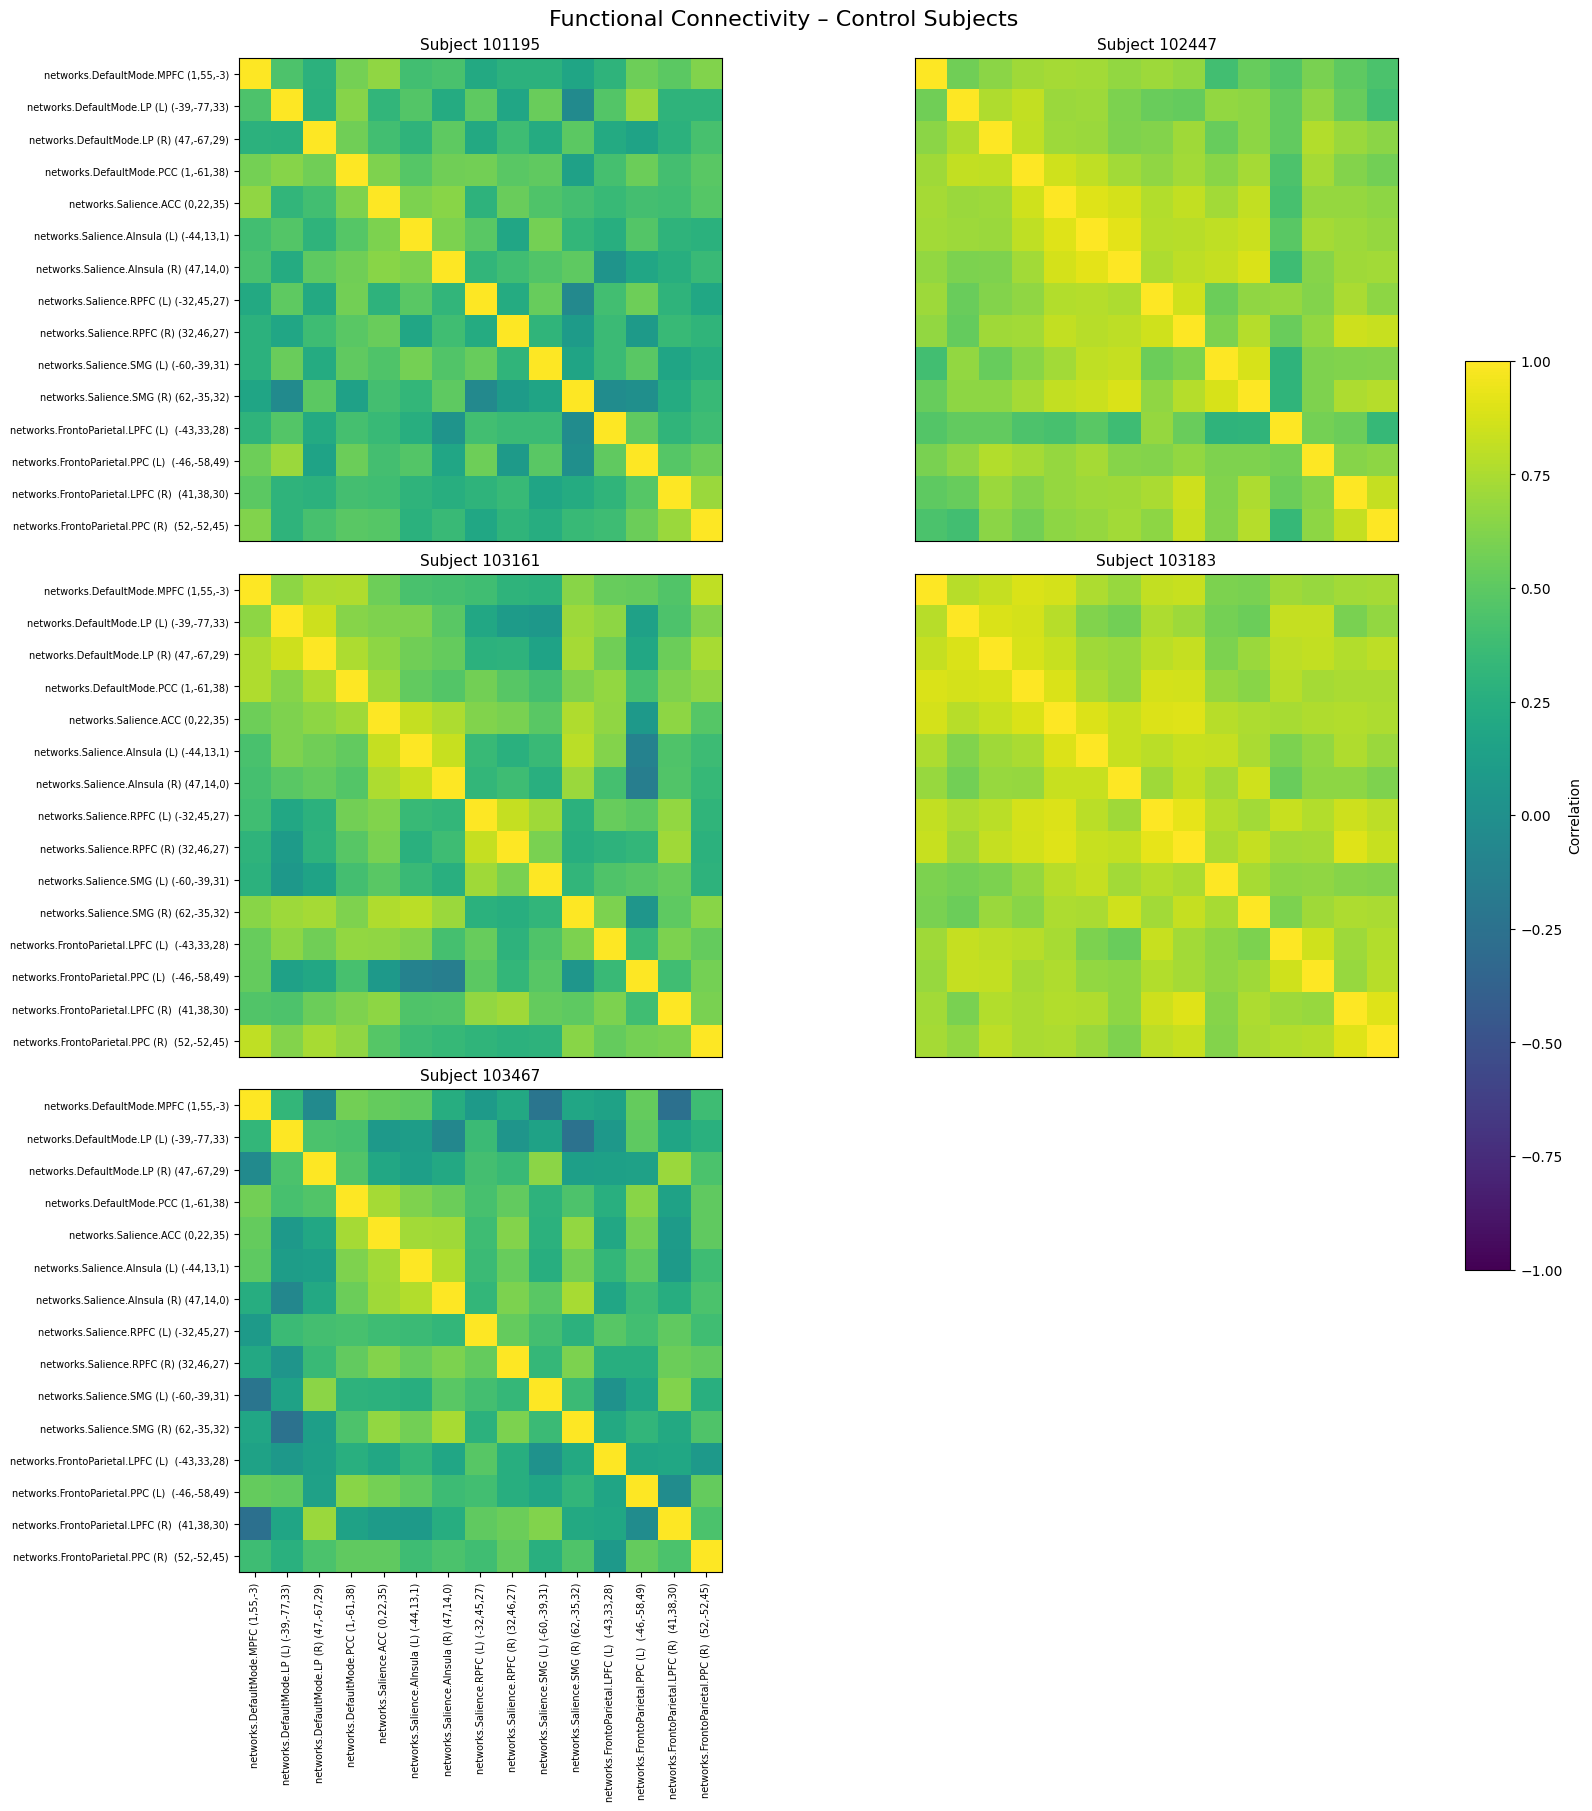

In [ ]:
#@title Control without depression
plot_fc_grid(
    FC_all_ctrl_r,
    ctrl_subjects,
    roi_labels,
    title="Functional Connectivity – Control Subjects"
)

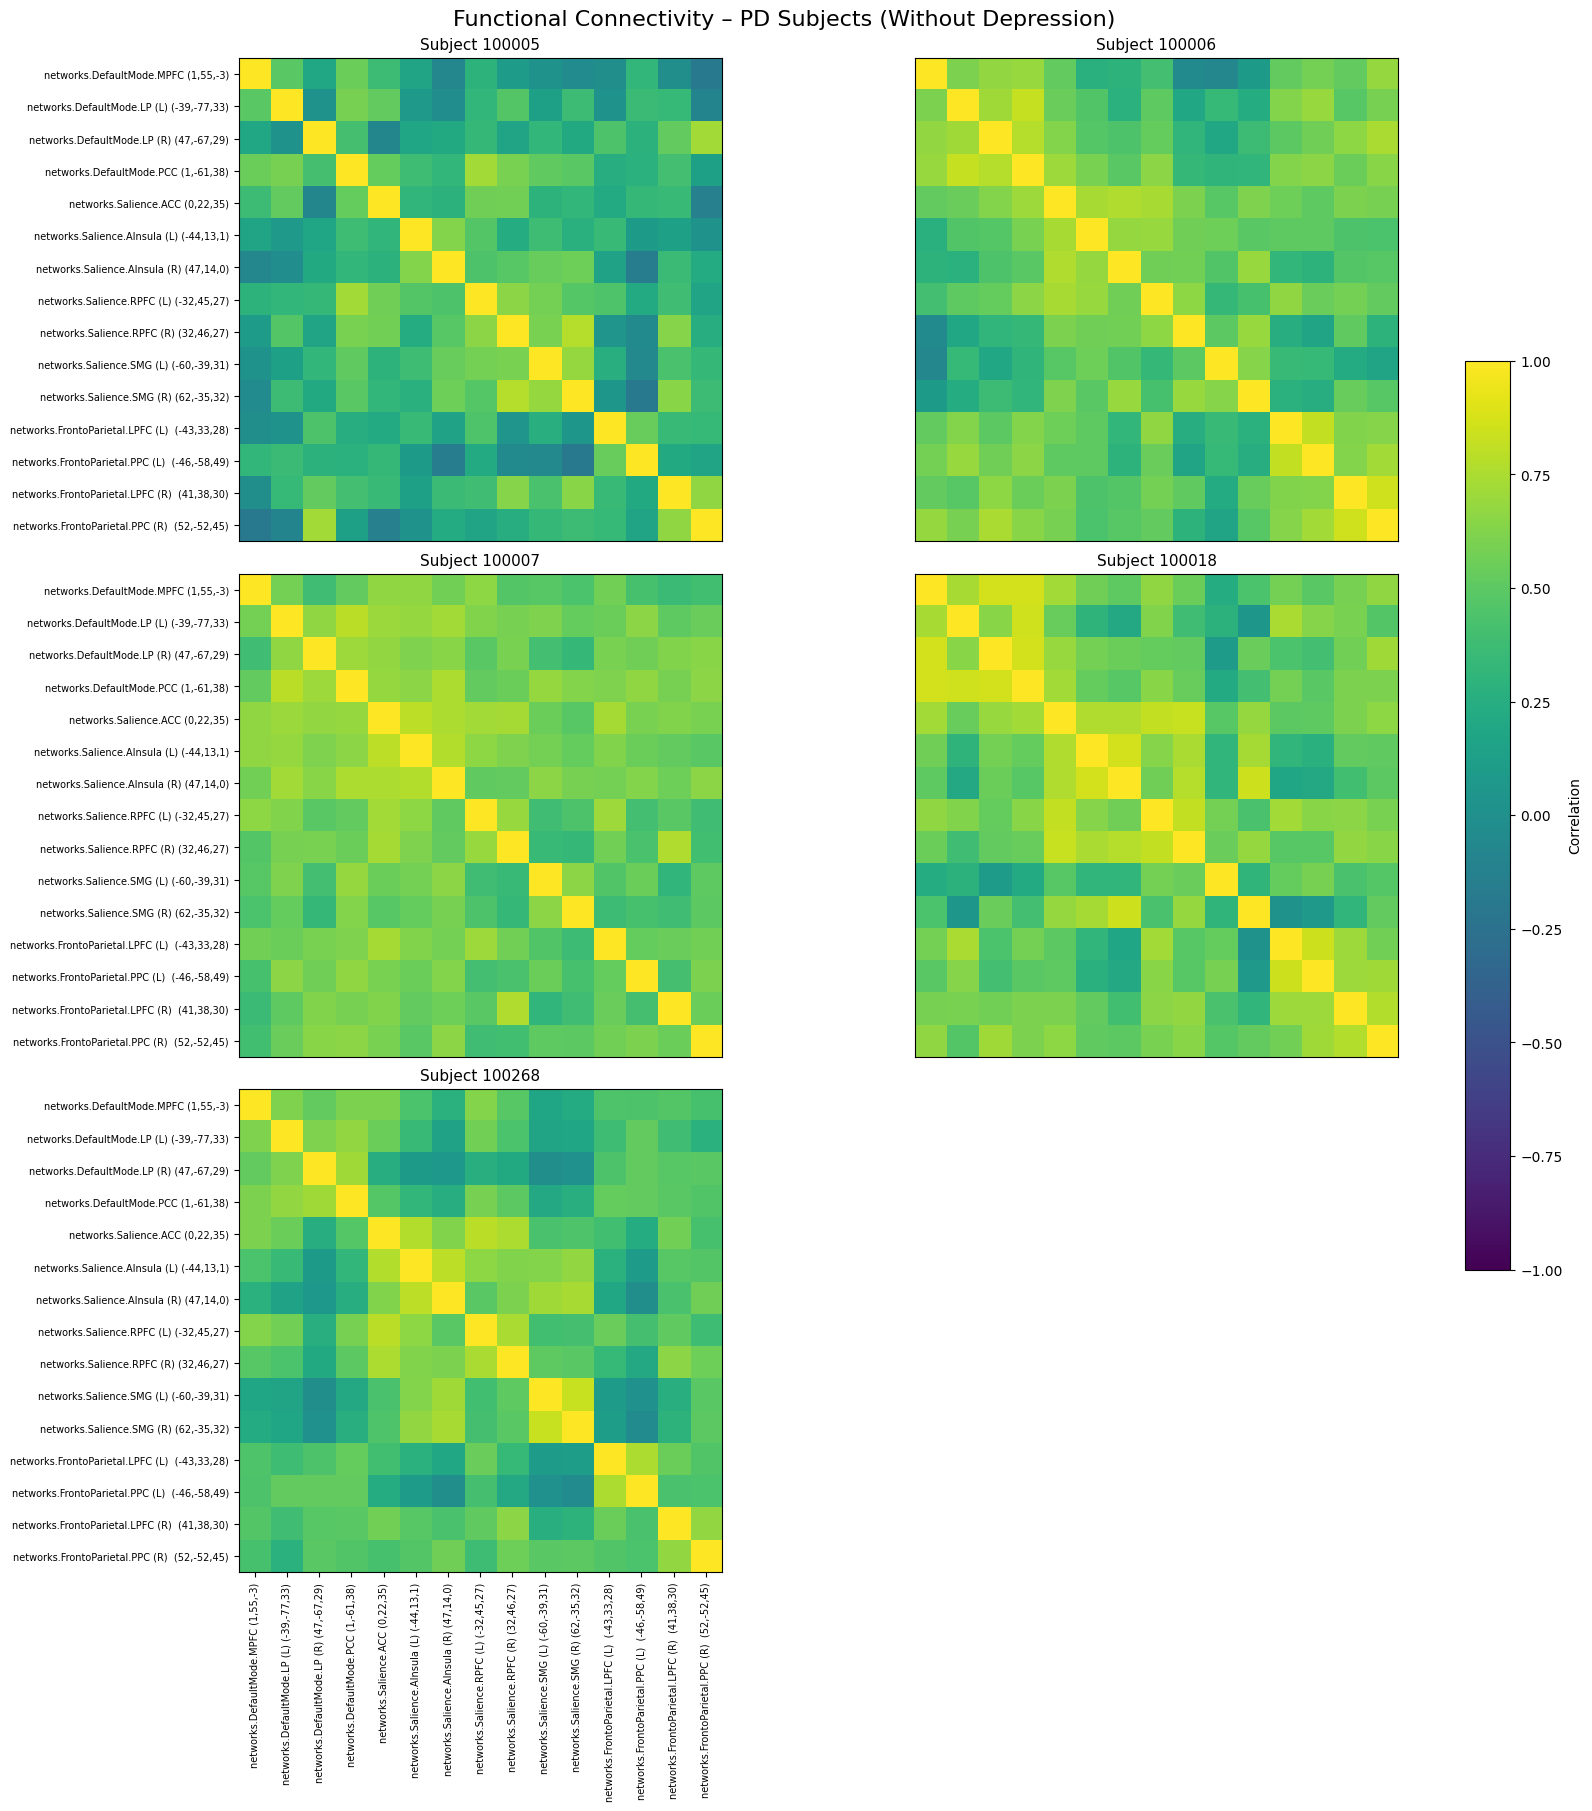

In [ ]:
#@title PD without depression
plot_fc_grid(
    FC_all_pd_r,
    pd_subjects,
    roi_labels,
    title="Functional Connectivity – PD Subjects (Without Depression)"
)


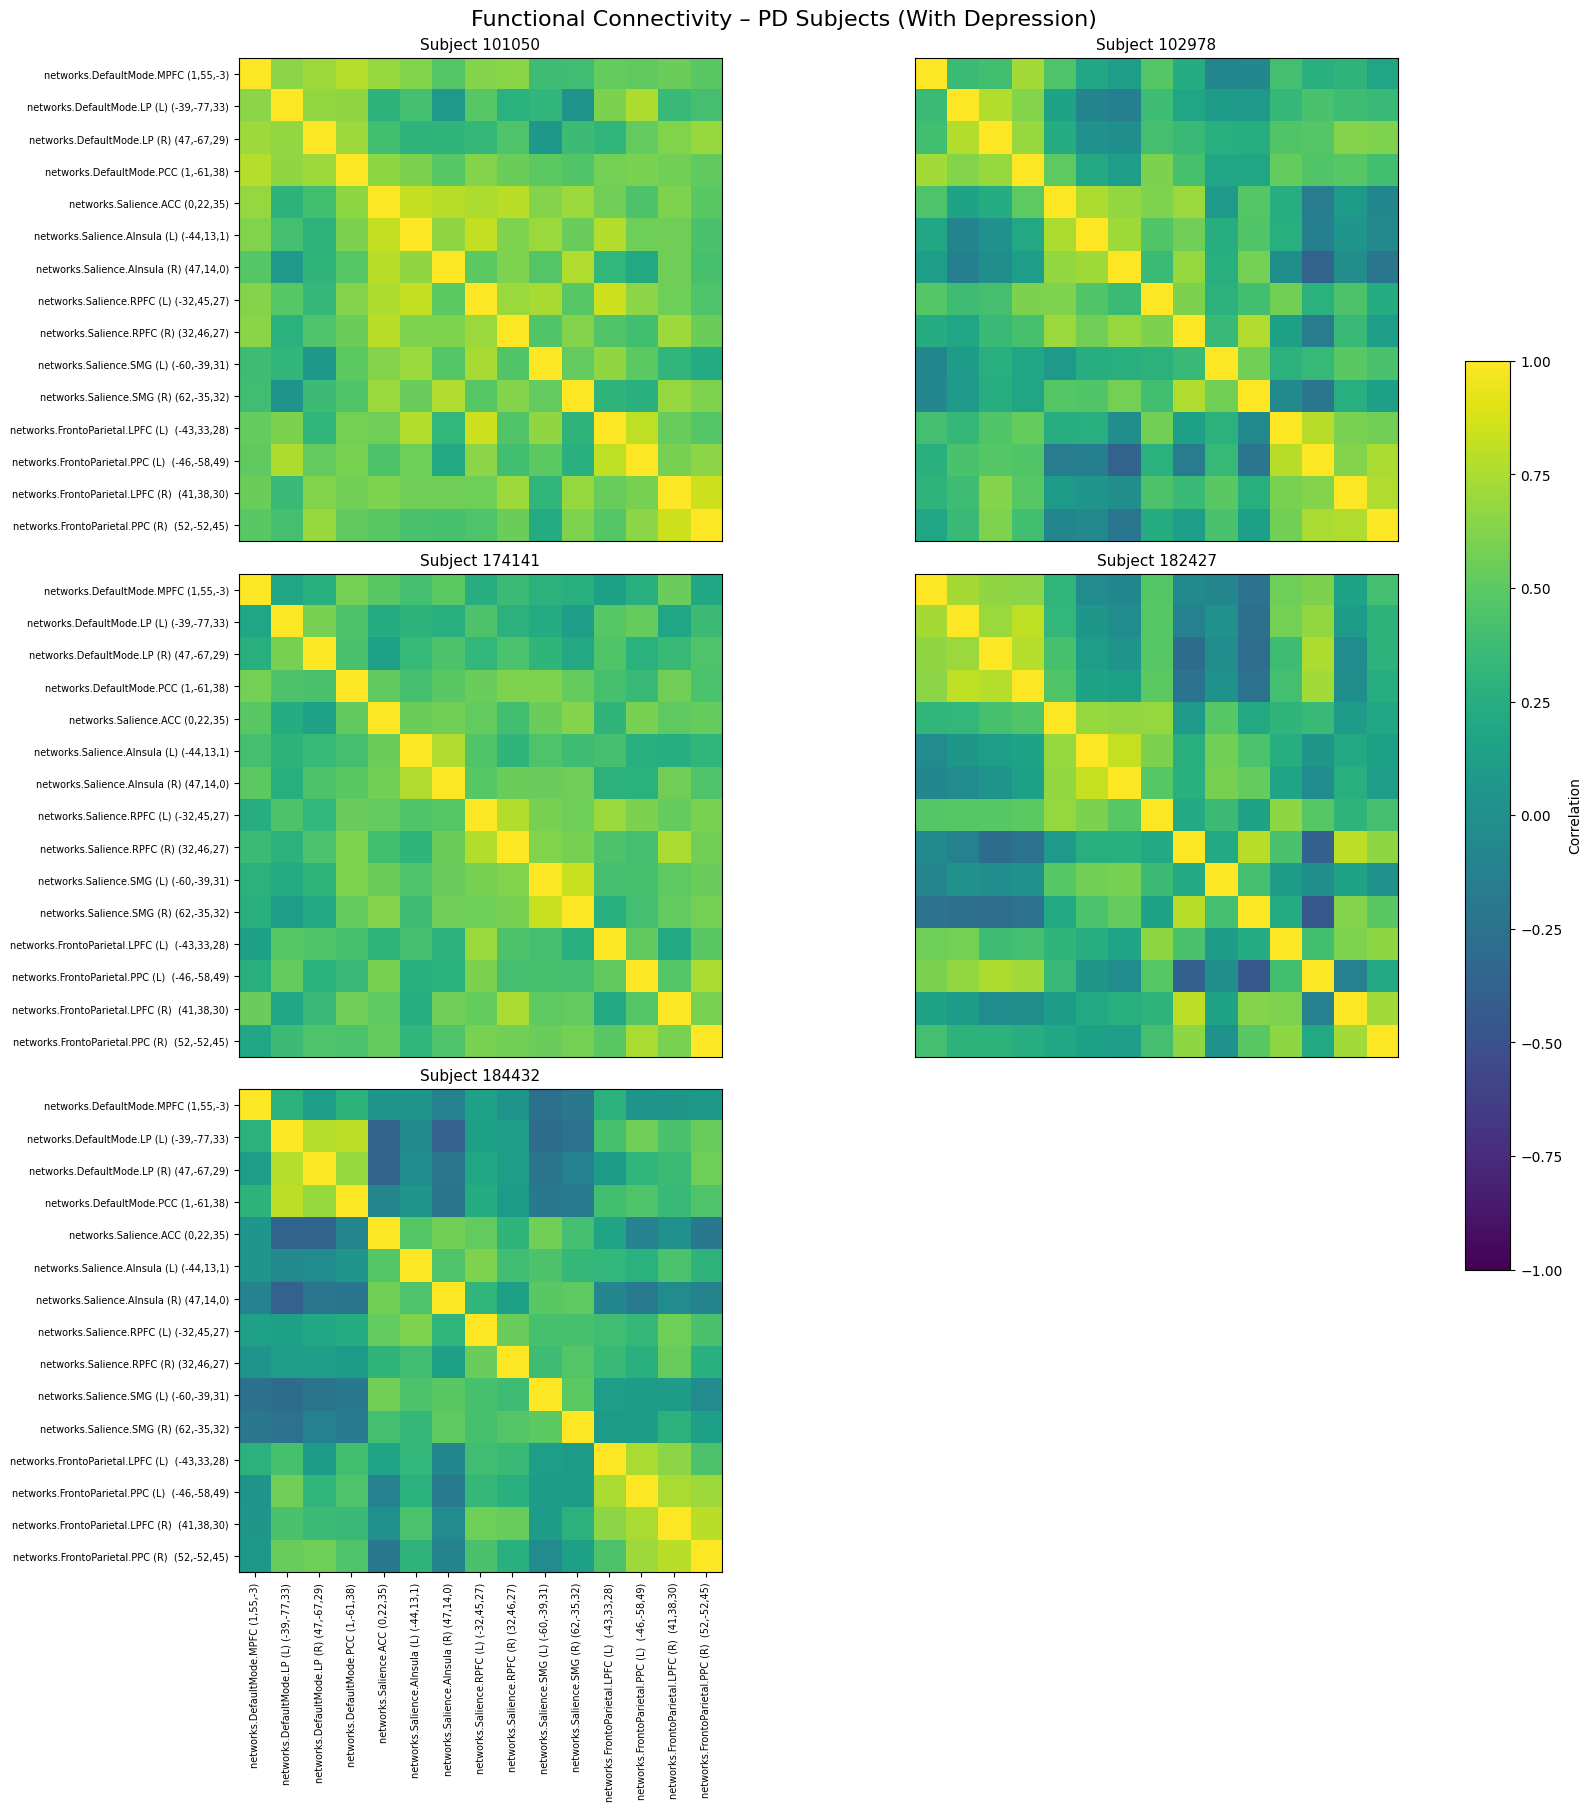

In [ ]:
#@title Control with depression
plot_fc_grid(
    FC_all_pd_dep_r,
    pd_subjects_dep,
    roi_labels,
    title="Functional Connectivity – PD Subjects (With Depression)"
)


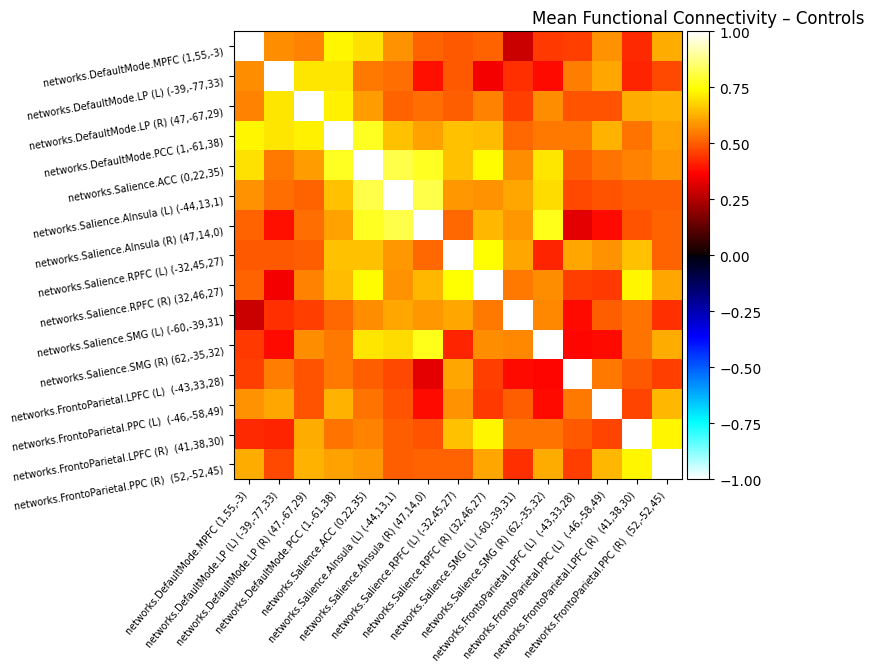

In [ ]:
#@title Mean FC
plotting.plot_matrix(
    FC_ctrl_mean_r,
    labels=roi_labels,
    vmin=-1,
    vmax=1,
    cmap="cold_hot",
    figure=(8, 8)
)
plt.title("Mean Functional Connectivity – Controls")
plt.show()


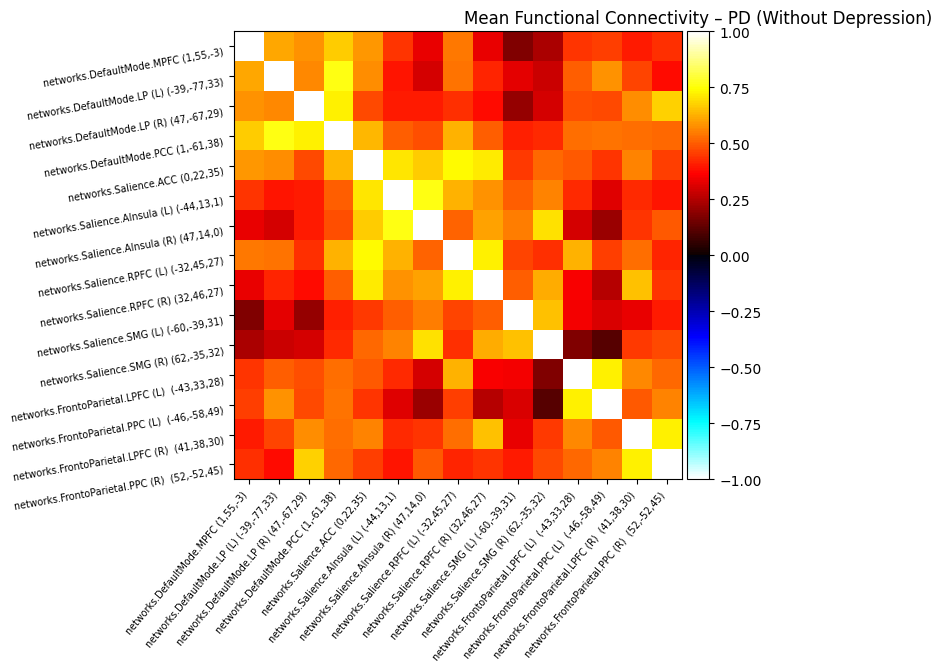

In [ ]:
plotting.plot_matrix(
    FC_pd_mean_r,
    labels=roi_labels,
    vmin=-1,
    vmax=1,
    cmap="cold_hot",
    figure=(8, 8)
)
plt.title("Mean Functional Connectivity – PD (Without Depression)")
plt.show()


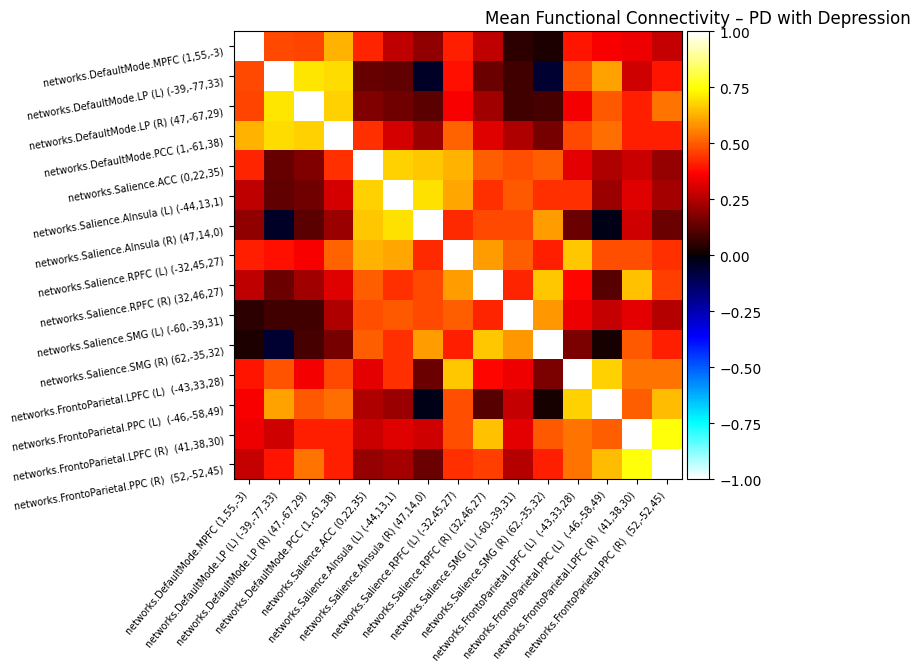

In [ ]:
plotting.plot_matrix(
    FC_pd_dep_mean_r,
    labels=roi_labels,
    vmin=-1,
    vmax=1,
    cmap="cold_hot",
    figure=(8, 8)
)
plt.title("Mean Functional Connectivity – PD with Depression")
plt.show()


In [ ]:
#@title Statistical Tests
n_rois = FC_all_ctrl_z.shape[1]
iu = np.triu_indices(n_rois, k=1)  # solo edges únicos
n_edges = len(iu[0])
print(f"Number of tested edges: {n_edges}")

Number of tested edges: 105


In [ ]:
from scipy.stats import ttest_ind

t_vals = np.zeros(n_edges)
p_vals = np.zeros(n_edges)

for k, (i, j) in enumerate(zip(iu[0], iu[1])):
    z_pd = FC_all_pd_z[:, i, j]
    z_pd_dep = FC_all_pd_dep_z[:, i, j]

    t, p = ttest_ind(
        z_pd,
        z_pd_dep,
        equal_var=False,   #Welch t-test
        nan_policy="omit"
    )

    t_vals[k] = t
    p_vals[k] = p


In [ ]:
from statsmodels.stats.multitest import multipletests

alpha = 0.05
rej, p_vals_fdr, _, _ = multipletests(
    p_vals,
    alpha=alpha,
    method="fdr_bh"
)

In [ ]:
T_matrix = np.zeros((n_rois, n_rois))
T_matrix[iu] = t_vals
T_matrix = T_matrix + T_matrix.T

In [ ]:
Sig_matrix = np.zeros((n_rois, n_rois), dtype=bool)
Sig_matrix[iu] = rej
Sig_matrix = Sig_matrix | Sig_matrix.T

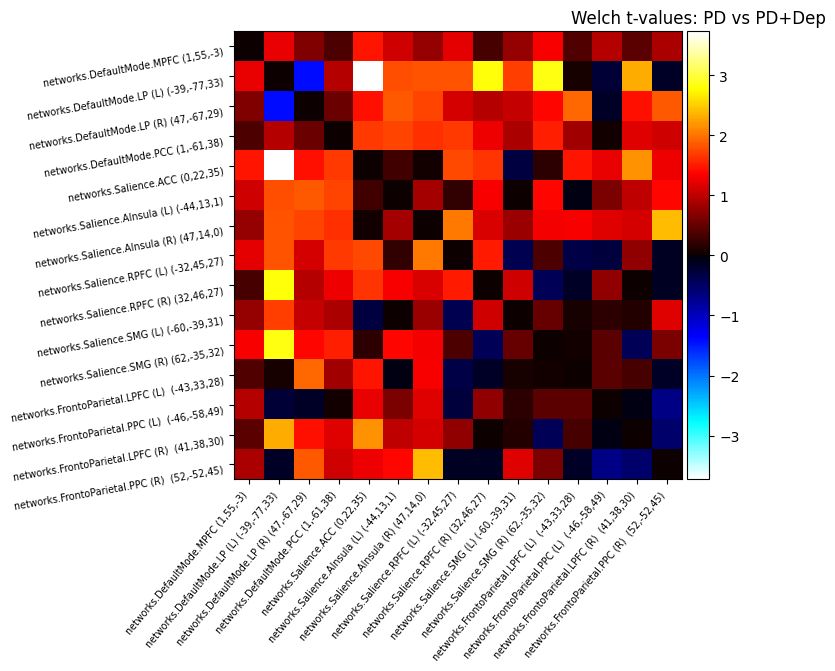

In [ ]:
plotting.plot_matrix(
    T_matrix,
    labels=roi_labels,
    cmap="cold_hot",
    figure=(8, 8),
    vmax=np.max(np.abs(T_matrix)),
    vmin=-np.max(np.abs(T_matrix))
)
plt.title("Welch t-values: PD vs PD+Dep")
plt.show()

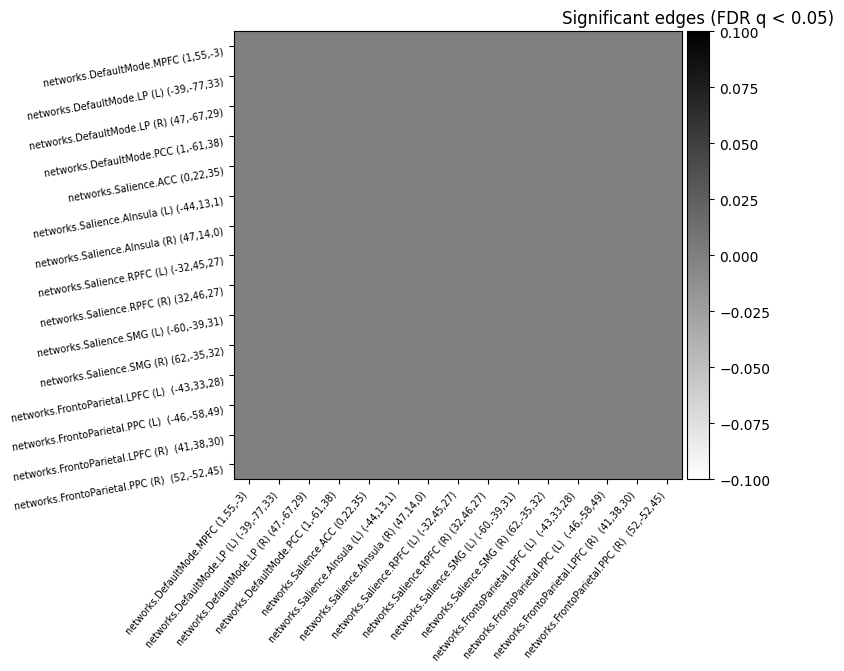

In [ ]:
plotting.plot_matrix(
    Sig_matrix.astype(int),
    labels=roi_labels,
    cmap="gray_r",
    figure=(8, 8)
)
plt.title("Significant edges (FDR q < 0.05)")
plt.show()

#Dynamic Functional Connectivity

In [ ]:
def dynamic_fc_from_roi(X, window_size=20, step_size=1):
    T, N = X.shape
    fc_windows = []

    taper = np.hamming(window_size)

    for start in range(0, T - window_size + 1, step_size):
        end = start + window_size

        Xw = X[start:end, :]           # (20, n_rois)
        Xw = Xw * taper[:, None]       # taper

        fc = np.corrcoef(Xw, rowvar=False)
        np.fill_diagonal(fc, 0.0)

        fc_windows.append(fc)

    return np.array(fc_windows)

In [ ]:
def mean_block(fc, idx1, idx2):
    return fc[np.ix_(idx1, idx2)].mean()

In [ ]:
TR = 2.5              # seconds
T = 240               # total timepoints
window_size = 20      # timesteps per window
step_size = 1         # shift in timesteps

In [ ]:
window_indices = [] # to assign which timepoints we are gonna collect

for start in range(0, T - window_size + 1, step_size):
    end = start + window_size
    idx = np.arange(start, end)
    window_indices.append(idx)

window_indices = np.array(window_indices)

In [ ]:
print("Number of windows:", len(window_indices))
print("Shape:", window_indices.shape)

Number of windows: 221
Shape: (221, 20)


In [ ]:
print(window_indices[:5])

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
 [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]]


In [ ]:
print(window_indices[-3:])

[[218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
  236 237]
 [219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
  237 238]
 [220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239]]


In [ ]:
window_centers = (window_indices[:, 0] + window_size / 2) * TR

In [ ]:
print(window_centers[:5])
print(window_centers[-5:])

[25.  27.5 30.  32.5 35. ]
[565.  567.5 570.  572.5 575. ]


In [ ]:
for i in range(3):
    start = i
    center_time = (start + window_size / 2) * TR
    print(f"Window {i}: center at {center_time} s")

Window 0: center at 25.0 s
Window 1: center at 27.5 s
Window 2: center at 30.0 s


In [ ]:
X_test = X_list_ctrl[0]
FC_dyn_test = dynamic_fc_from_roi(X_test)

print(FC_dyn_test.shape)

(221, 15, 15)


In [ ]:
print("NaNs:", np.isnan(FC_dyn_test).sum())
print("Infs:", np.isinf(FC_dyn_test).sum())

NaNs: 0
Infs: 0


In [ ]:
#@title Ctrl data
FC_dyn_ctrl = []

for X in X_list_ctrl:
    fc_dyn = dynamic_fc_from_roi(X)   # (221, 15, 15)
    FC_dyn_ctrl.append(fc_dyn)

FC_dyn_ctrl = np.array(FC_dyn_ctrl)
FC_dyn_ctrl_z =  np.arctanh(FC_dyn_ctrl) # fisher

In [ ]:
#@title PD data without depression
FC_dyn_pd = []

for X in X_list_pd:
    fc_dyn = dynamic_fc_from_roi(X)
    FC_dyn_pd.append(fc_dyn)

FC_dyn_pd = np.array(FC_dyn_pd)

FC_dyn_pd_z =  np.arctanh(FC_dyn_pd) # fisher

In [ ]:
#@title PD data with depression
FC_dyn_pd_dep = []

for X in X_list_pd_dep:
    fc_dyn = dynamic_fc_from_roi(X)
    FC_dyn_pd_dep.append(fc_dyn)

FC_dyn_pd_dep = np.array(FC_dyn_pd_dep)
FC_dyn_pd_dep_z = np.arctanh(FC_dyn_pd_dep) # fisher

In [ ]:
print(FC_dyn_ctrl.shape)
print(FC_dyn_pd.shape)
print(FC_dyn_pd_dep.shape)

(5, 221, 15, 15)
(5, 221, 15, 15)
(5, 221, 15, 15)


In [ ]:
DMN = [i for i, n in enumerate(roi_interest_names_ctrl) if "DefaultMode" in n] # could be any label
SAL = [i for i, n in enumerate(roi_interest_names_ctrl) if "Salience" in n]
FPN = [i for i, n in enumerate(roi_interest_names_ctrl) if "FrontoParietal" in n]

print(len(DMN), len(SAL), len(FPN))

4 7 4


In [ ]:
def get_connectivity_windows(fc_subj):
  dmn_fpn = np.array([mean_block(fc, DMN, FPN) for fc in fc_subj])
  dmn_sal = np.array([mean_block(fc, DMN, SAL) for fc in fc_subj])
  sal_fpn = np.array([mean_block(fc, SAL, FPN) for fc in fc_subj])
  #dmn_dmn = np.array([mean_block(fc, DMN, DMN) for fc in fc_subj])
  return dmn_fpn, dmn_sal, sal_fpn


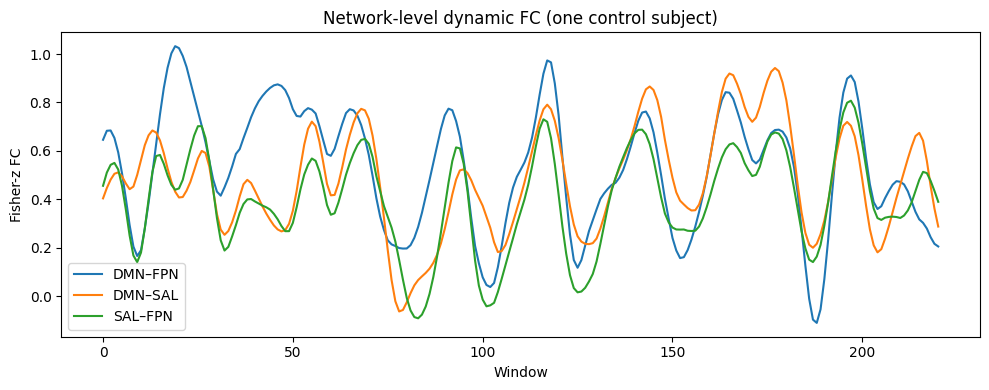

In [ ]:
fc_subj = FC_dyn_ctrl_z[0]   # (221, 15, 15)
dmn_fpn, dmn_sal, sal_fpn = get_connectivity_windows(fc_subj)
plt.figure(figsize=(10,4))
plt.plot(dmn_fpn, label="DMN–FPN")
plt.plot(dmn_sal, label="DMN–SAL")
plt.plot(sal_fpn, label="SAL–FPN")
#plt.plot(dmn_dmn, label="DMN–DMN")
plt.xlabel("Window")
plt.ylabel("Fisher-z FC")
plt.legend()
plt.title("Network-level dynamic FC (one control subject)")
plt.tight_layout()
plt.show()

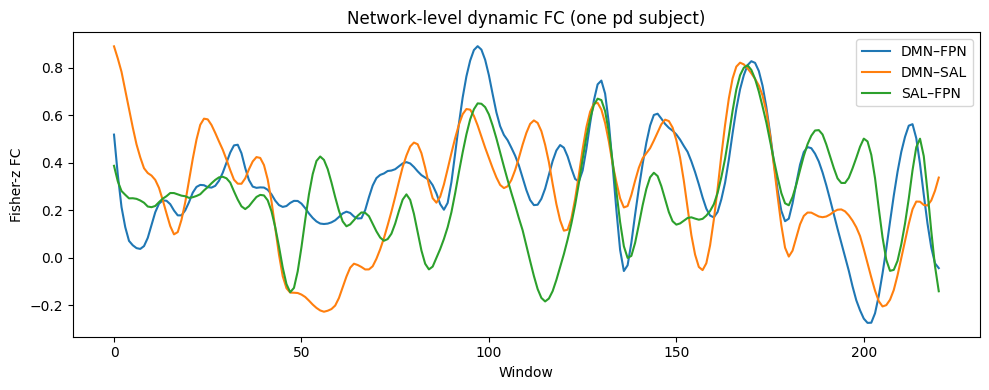

In [ ]:
fc_subj = FC_dyn_pd_z[0]   # (221, 15, 15)
dmn_fpn, dmn_sal, sal_fpn = get_connectivity_windows(fc_subj)
plt.figure(figsize=(10,4))
plt.plot(dmn_fpn, label="DMN–FPN")
plt.plot(dmn_sal, label="DMN–SAL")
plt.plot(sal_fpn, label="SAL–FPN")
#plt.plot(dmn_dmn, label="DMN–DMN")
plt.xlabel("Window")
plt.ylabel("Fisher-z FC")
plt.legend()
plt.title("Network-level dynamic FC (one pd subject)")
plt.tight_layout()
plt.show()

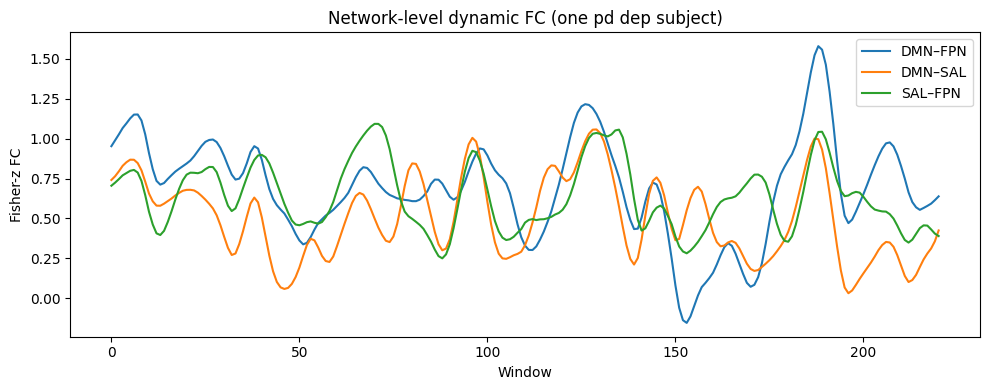

In [ ]:
fc_subj = FC_dyn_pd_dep_z[0]   # (221, 15, 15)
dmn_fpn, dmn_sal, sal_fpn = get_connectivity_windows(fc_subj)
plt.figure(figsize=(10,4))
plt.plot(dmn_fpn, label="DMN–FPN")
plt.plot(dmn_sal, label="DMN–SAL")
plt.plot(sal_fpn, label="SAL–FPN")
#plt.plot(dmn_dmn, label="DMN–DMN")
plt.xlabel("Window")
plt.ylabel("Fisher-z FC")
plt.legend()
plt.title("Network-level dynamic FC (one pd dep subject)")
plt.tight_layout()
plt.show() # seems like a hyperconnectivity

In [173]:
def compute_dynamic_coupling(dmn_fpn, dmn_sal, sal_fpn):
    return {
        "DMN–FPN vs DMN–SAL": np.corrcoef(dmn_fpn, dmn_sal)[0, 1],
        "DMN–FPN vs SAL–FPN": np.corrcoef(dmn_fpn, sal_fpn)[0, 1],
        "DMN–SAL vs SAL–FPN": np.corrcoef(dmn_sal, sal_fpn)[0, 1],
    }

In [168]:
def plot_all_subjects_dynamic_fc(
    fc_dyn_group_z,
    subjects,
    gdsc,
    group_name="Group",
    n_cols=2
):

    n_subjects = fc_dyn_group_z.shape[0]
    n_rows = math.ceil(n_subjects / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(12, 4 * n_rows),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()  # easier indexing

    for i, fc_subj in enumerate(fc_dyn_group_z):
        ax = axes[i]

        dmn_fpn, dmn_sal, sal_fpn = get_connectivity_windows(fc_subj)

        ax.plot(dmn_fpn, label="DMN–FPN")
        ax.plot(dmn_sal, label="DMN–SAL")
        ax.plot(sal_fpn, label="SAL–FPN")

        ax.set_title(f"Subject {subjects[i]} - GDSC {gdsc[i]}")
        ax.set_xlabel("Window")
        ax.set_ylabel("Pearson FC")
        ax.legend(fontsize=8)
        ax.grid()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Network-level dynamic FC ({group_name})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [178]:
def plot_all_subjects_dynamic_fc(
    fc_dyn_group_z,
    subjects,
    gdsc,
    group_name="Group",
    n_cols=2
):

    n_subjects = fc_dyn_group_z.shape[0]
    n_rows = math.ceil(n_subjects / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(12, 4 * n_rows),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()

    coupling_results = {}

    for i, fc_subj in enumerate(fc_dyn_group_z):
        ax = axes[i]

        dmn_fpn, dmn_sal, sal_fpn = get_connectivity_windows(fc_subj)

        # --- plot ---
        ax.plot(dmn_fpn, label="DMN–FPN")
        ax.plot(dmn_sal, label="DMN–SAL")
        ax.plot(sal_fpn, label="SAL–FPN")

        # --- compute coupling ---
        coupling = compute_dynamic_coupling(dmn_fpn, dmn_sal, sal_fpn)
        coupling_results[subjects[i]] = coupling

        # --- annotate coupling (small & clean) ---
        coupling_text = (
        f"DMN–FPN ↔ DMN–SAL: {coupling['DMN–FPN vs DMN–SAL']:.2f}\n"
        f"DMN–FPN ↔ SAL–FPN: {coupling['DMN–FPN vs SAL–FPN']:.2f}\n"
        f"DMN–SAL ↔ SAL–FPN: {coupling['DMN–SAL vs SAL–FPN']:.2f}"
    )

        ax.text(
            0.02, 0.95,
            coupling_text,
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment="top",
            bbox=dict(boxstyle="round", alpha=0.15)
        )

        ax.set_title(f"Subject {subjects[i]} – GDSC {gdsc[i]}")
        ax.set_xlabel("Window")
        ax.set_ylabel("Fisher-z FC")
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Network-level dynamic FC ({group_name})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return coupling_results


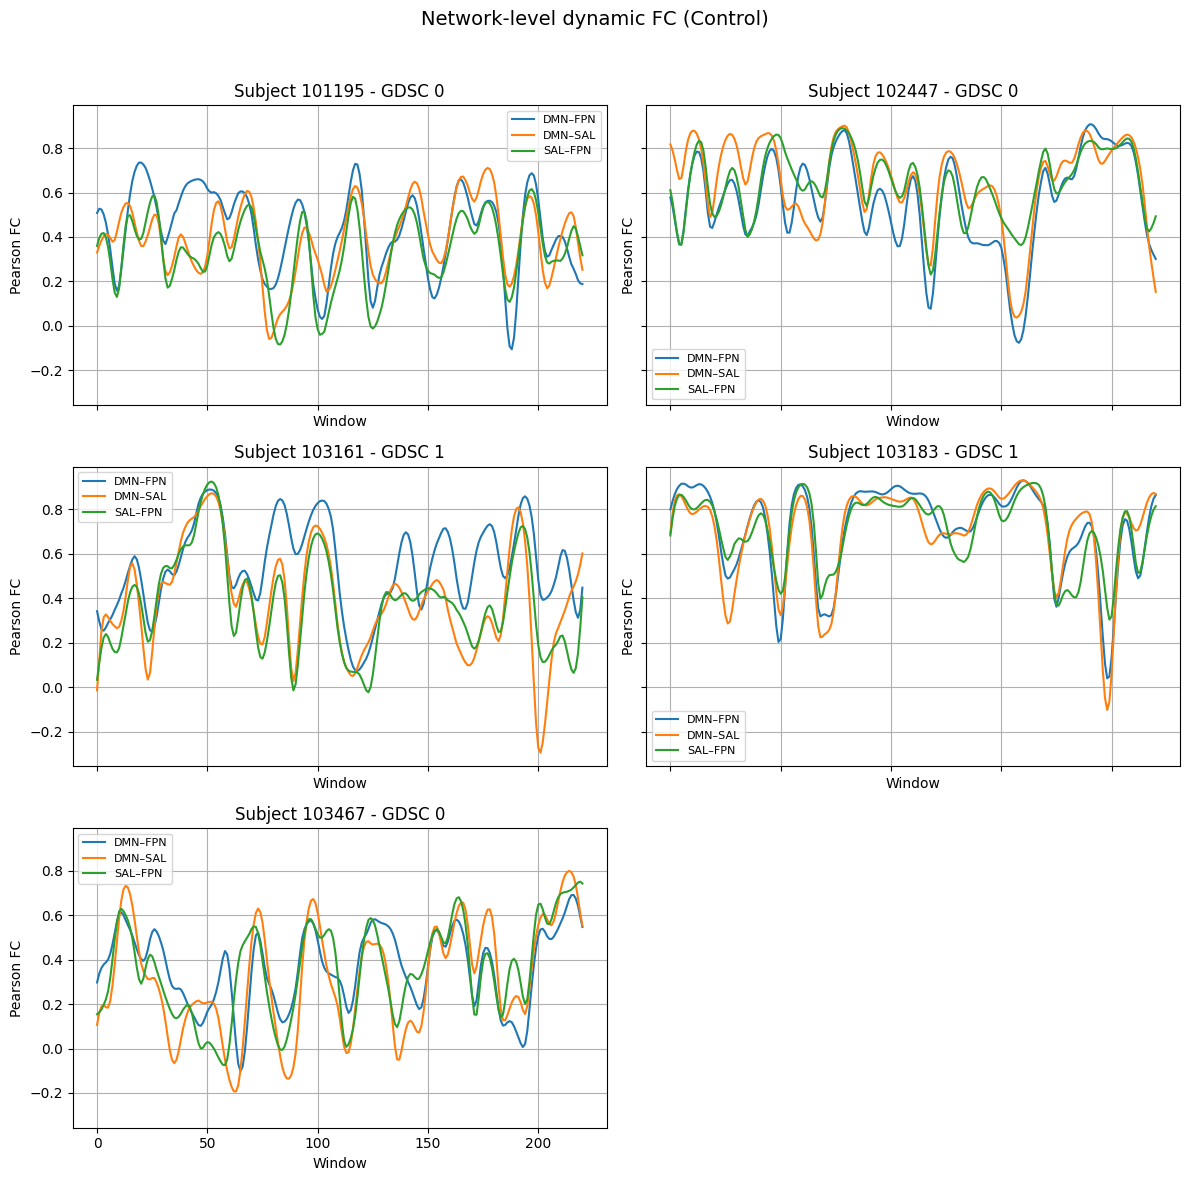

In [169]:
#@title DFC Ctrl
plot_all_subjects_dynamic_fc(
    FC_dyn_ctrl,
    ctrl_subjects,
    ctrl_subjects_gdsc,
    group_name="Control"
)

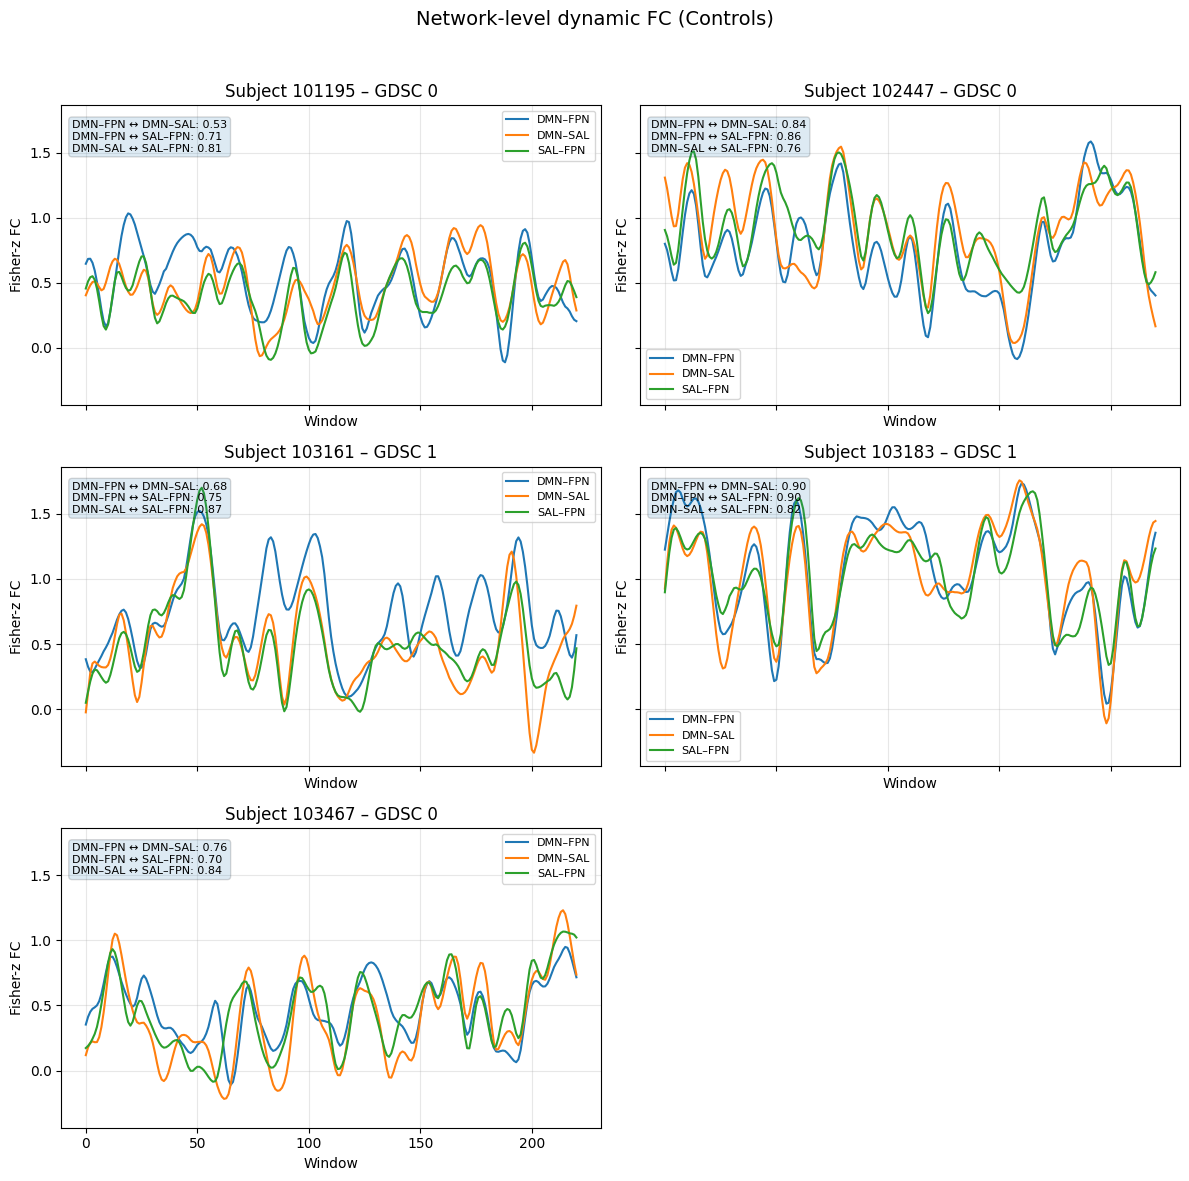

In [179]:
coupling_ctrl = plot_all_subjects_dynamic_fc(
    FC_dyn_ctrl_z,
    ctrl_subjects,
    ctrl_subjects_gdsc,
    group_name="Controls"
)

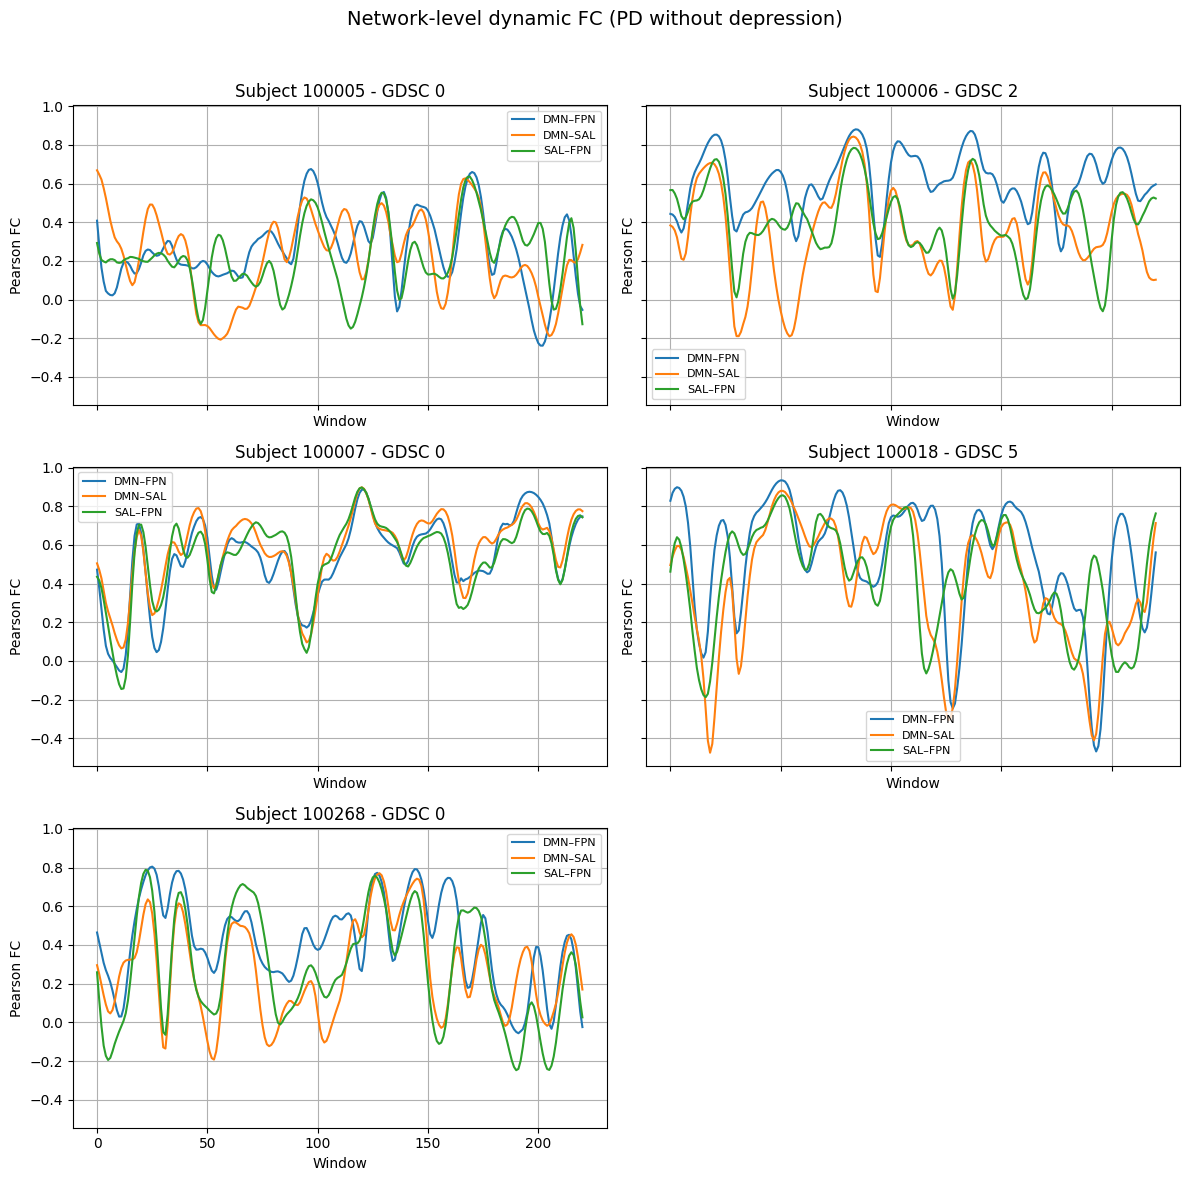

In [170]:
#@title DFC PD without depression
plot_all_subjects_dynamic_fc(
    FC_dyn_pd,
    pd_subjects,
    pd_subjects_gdsc,
    group_name="PD without depression"
)

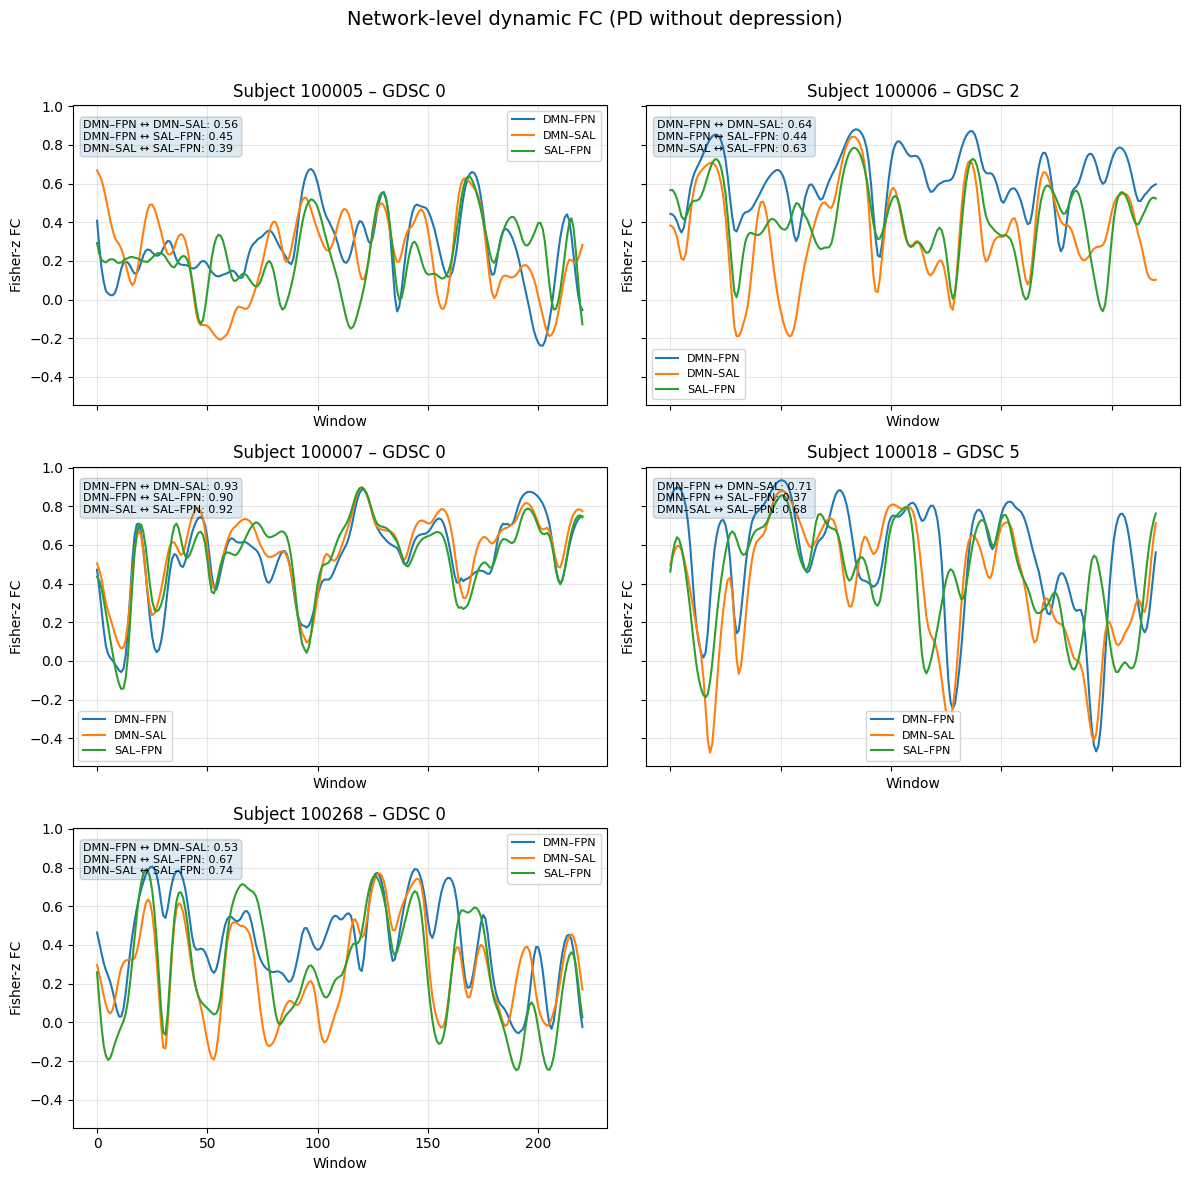

In [180]:
coupling_pd = plot_all_subjects_dynamic_fc(
    FC_dyn_pd,
    pd_subjects,
    pd_subjects_gdsc,
    group_name="PD without depression"
)

In [187]:
coupling_pd_dep

{101050: {'DMN–FPN vs DMN–SAL': np.float64(0.4486319926030599),
  'DMN–FPN vs SAL–FPN': np.float64(0.4648983445590849),
  'DMN–SAL vs SAL–FPN': np.float64(0.37520599821088496)},
 102978: {'DMN–FPN vs DMN–SAL': np.float64(0.23182659354016563),
  'DMN–FPN vs SAL–FPN': np.float64(0.53195301353472),
  'DMN–SAL vs SAL–FPN': np.float64(0.5261953123205761)},
 174141: {'DMN–FPN vs DMN–SAL': np.float64(0.7174956558090939),
  'DMN–FPN vs SAL–FPN': np.float64(0.5297267351476067),
  'DMN–SAL vs SAL–FPN': np.float64(0.6275208057010464)},
 182427: {'DMN–FPN vs DMN–SAL': np.float64(0.1697552709282794),
  'DMN–FPN vs SAL–FPN': np.float64(-0.14748545800132526),
  'DMN–SAL vs SAL–FPN': np.float64(0.5927303766718536)},
 184432: {'DMN–FPN vs DMN–SAL': np.float64(0.4916795146180683),
  'DMN–FPN vs SAL–FPN': np.float64(-0.03779189898732883),
  'DMN–SAL vs SAL–FPN': np.float64(0.6275033493880665)}}

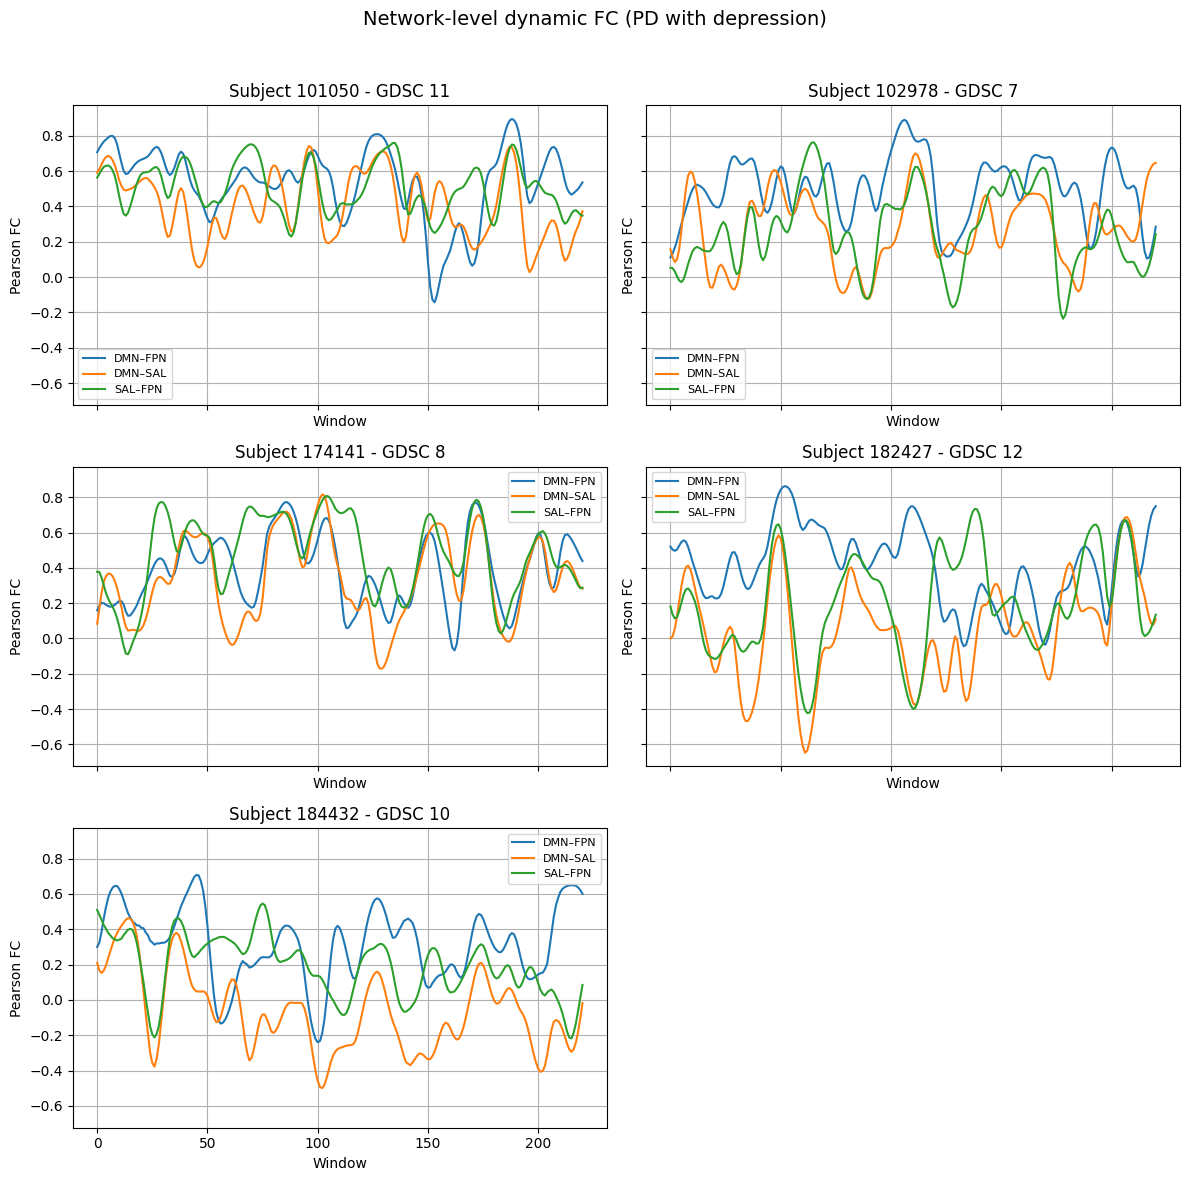

In [171]:
#@title DFC PD with depression
plot_all_subjects_dynamic_fc(
    FC_dyn_pd_dep,
    pd_subjects_dep,
    pd_dep_subjects_gdsc,
    group_name="PD with depression"
)

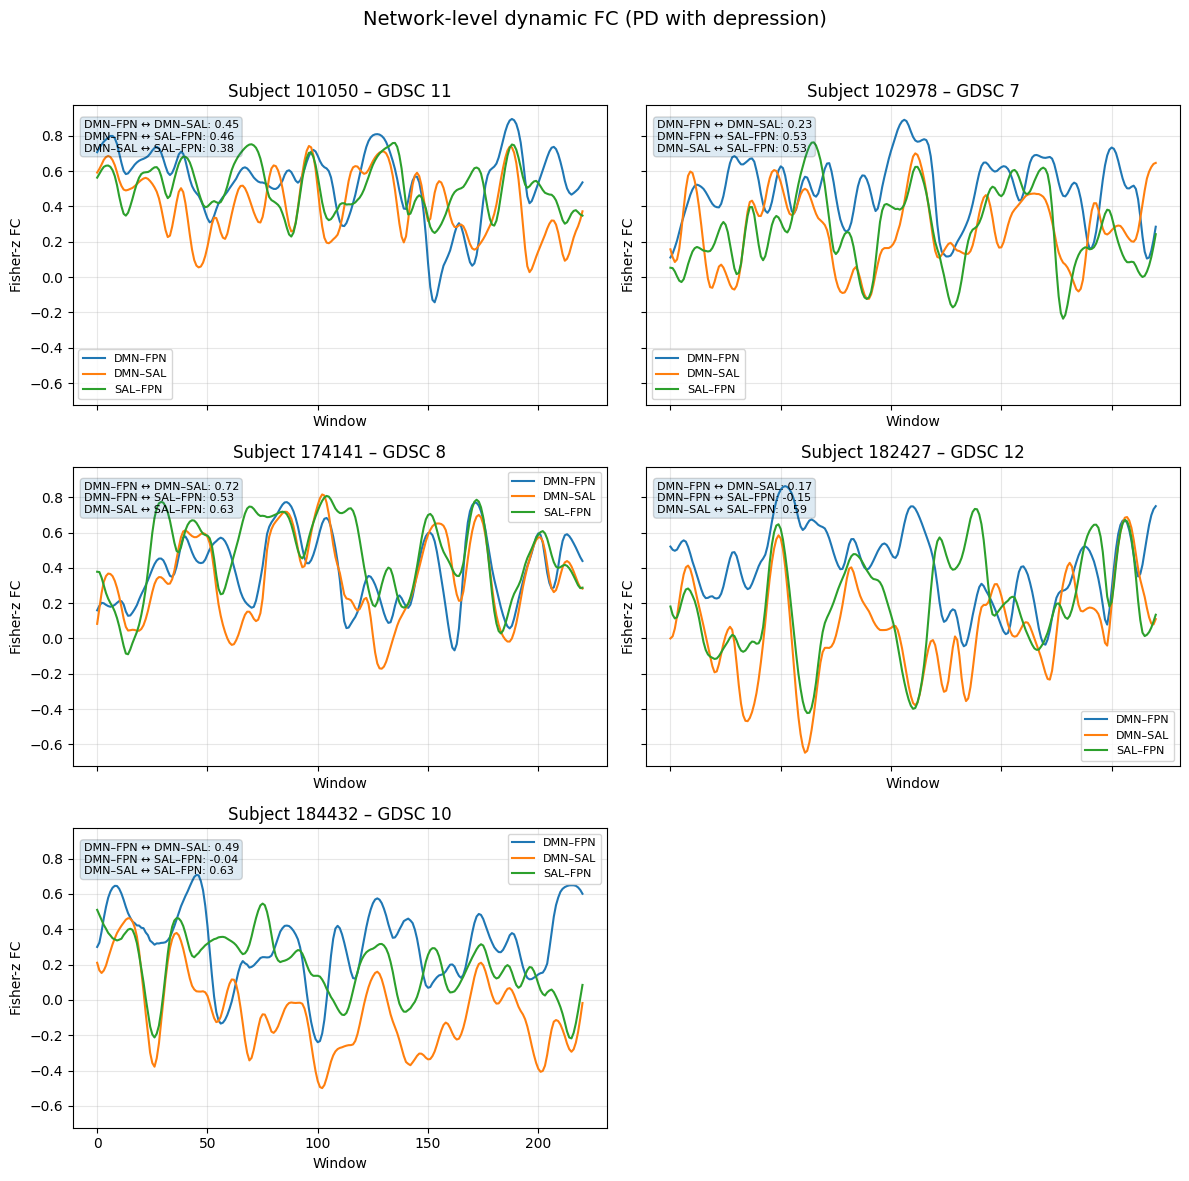

In [181]:
coupling_pd_dep = plot_all_subjects_dynamic_fc(
    FC_dyn_pd_dep,
    pd_subjects_dep,
    pd_dep_subjects_gdsc,
    group_name="PD with depression"
)

In [188]:
#@title Statistical tests
def coupling_dict_to_df(coupling_dict, group_name):
    rows = []

    for subject, couplings in coupling_dict.items():
        for pair, value in couplings.items():
            rows.append({
                "subject": subject,
                "group": group_name,
                "pair": pair,
                "coupling": float(value)
            })

    return pd.DataFrame(rows)

In [189]:
df_ctrl = coupling_dict_to_df(coupling_ctrl, "Control")
df_pd = coupling_dict_to_df(coupling_pd, "PD")
df_pd_dep = coupling_dict_to_df(coupling_pd_dep, "PD_Dep")

In [190]:
df_coupling = pd.concat(
    [df_ctrl, df_pd, df_pd_dep],
    ignore_index=True
)

In [192]:
df_coupling.head()

subject    group                pair  coupling
0   101195  Control  DMN–FPN vs DMN–SAL  0.534424
1   101195  Control  DMN–FPN vs SAL–FPN  0.709869
2   101195  Control  DMN–SAL vs SAL–FPN  0.807387
3   102447  Control  DMN–FPN vs DMN–SAL  0.837352
4   102447  Control  DMN–FPN vs SAL–FPN  0.857056

In [207]:
def get_dict(pair_name):
  ctrl_vals = df_coupling[
      (df_coupling["group"] == "Control") &
      (df_coupling["pair"] == pair_name)
  ]["coupling"]

  pd_vals = df_coupling[
      (df_coupling["group"] == "PD") &
      (df_coupling["pair"] == pair_name)
  ]["coupling"]

  pd_dep_vals = df_coupling[
      (df_coupling["group"] == "PD_Dep") &
      (df_coupling["pair"] == pair_name)
  ]["coupling"]

  return ctrl_vals,pd_vals,pd_dep_vals

In [221]:
def kw_with_posthoc(ctrl_vals, pd_vals, pd_dep_vals, metric_name):
    print(f"\nKruskal–Wallis for {metric_name}")

    H, p_kw = kruskal(ctrl_vals, pd_vals, pd_dep_vals)
    print(f"H = {H:.3f}, p = {p_kw:.4f}")

    if p_kw < 0.06:
        print("Mann–Whitney tests:")

        comparisons = {
            "Control vs PD": (ctrl_vals, pd_vals),
            "Control vs PD_Dep": (ctrl_vals, pd_dep_vals),
            "PD vs PD_Dep": (pd_vals, pd_dep_vals),
        }

        for name, (x, y) in comparisons.items():
            U, p = mannwhitneyu(x, y, alternative="two-sided")
            print(f"  {name}: U = {U:.3f}, p = {p:.4f}")
    else:
        print("→ Global test not significant")

In [223]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

pair_names = [
    "DMN–SAL vs SAL–FPN",
    "DMN–FPN vs SAL–FPN",
    "DMN–FPN vs DMN–SAL"
]

for pair_name in pair_names:
    ctrl_vals, pd_vals, pd_dep_vals = get_dict(pair_name)
    kw_with_posthoc(ctrl_vals, pd_vals, pd_dep_vals, pair_name)



Kruskal–Wallis for DMN–SAL vs SAL–FPN
H = 8.420, p = 0.0148
Mann–Whitney tests:
  Control vs PD: U = 20.000, p = 0.1508
  Control vs PD_Dep: U = 25.000, p = 0.0079
  PD vs PD_Dep: U = 21.000, p = 0.0952

Kruskal–Wallis for DMN–FPN vs SAL–FPN
H = 7.220, p = 0.0271
Mann–Whitney tests:
  Control vs PD: U = 21.000, p = 0.0952
  Control vs PD_Dep: U = 25.000, p = 0.0079
  PD vs PD_Dep: U = 16.000, p = 0.5476

Kruskal–Wallis for DMN–FPN vs DMN–SAL
H = 5.820, p = 0.0545
Mann–Whitney tests:
  Control vs PD: U = 16.000, p = 0.5476
  Control vs PD_Dep: U = 23.000, p = 0.0317
  PD vs PD_Dep: U = 21.000, p = 0.0952


#Network-level connectivity

#Graph-theoretical metrics

#Dynamic Functional Connectivity

#Interpretability & visualization